### Faithful simulation of polarization enatnglement distribution in the SeQUeNCe Quantum Network simulator. 

The goal of this work is to simulate the experiment described in [[1](https://opg.optica.org/abstract.cfm?uri=CLEO_FS-2023-FF3A.7)] paper.

 We model devices like entangled photon sources, optical fibers, detectors, etc. in the SeQUeNCe quantum network simulator and use this notebook to call the devices and prepare a simple point to point network of two modes with a source in the middle (mid point source [[2](https://arxiv.org/abs/1505.01536)])

 This work can be found in the ```polarizationFock-and-Tensor-Networks``` branch on SeQUeNCe. 

## Import Requirements

In [27]:
from copy import copy
from time import time
import matplotlib
matplotlib.rc('font',family='sans')
import matplotlib.patches as patches
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize

from sequence.components.polarization_fock.node_definitions import *
from sequence.kernel.timeline import Timeline
from sequence.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM

import json
import csv

## Simulation Setup
We set parameters required for running the experiment. We primarily consider three noise/loss models:source multi-pair effects (calculated analytically based on experimental visibilities), fiber amplitude damping (from original experiment) and detector inefficiency (ad hoc value, estiamted heuristically later) and understand their detriment on polarization entanglement distribution. 

We also set the cut off for the number of photons each bosonic mode can accomodate (called truncation) and also the angles we use to set the rotators at the signal and idler rotators at to analyse the polarization entanglement. 

In [19]:
params = {
    # Light source
    "MEAN_PHOTON_NUM" : 0.0597,

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.9,
    "IDLER_DET_EFFICIENCY" : 0.9, 

    # fibers
    "SIGNAL_DIST" : 6.1, 
    "IDLER_DIST" : 6.1,  
    "QUNATUM_ATTENUATION" : 7.1/6.1,  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "signal_angles" : np.linspace(0, 2*np.pi, 20),
    "idler_angles" : [0, np.pi/2, np.pi, 3*np.pi/2],
    "MODE_NUM" : 4,
    "truncation" : 4,

    # Future development params:
    "QUANTUM_WAVELENGTH" : 1550,
    "SPDC_FREQUENCY" : 1e10,
    "POLARIZATION_FIDELITY" : 0.8,
    "TEMPORAL_COINCIDENCE_WINDOW": 400
}

## Network Setup

Creating the network described in the setup shown on the top of this notebook. 

![image](experiment.png)

In [20]:
def setup_network(timeline, params):
    signal_receiver_port_name = "signal_receiver_port"
    idler_receiver_port_name = "idler_receiver_port"

    receiver_port_list = [signal_receiver_port_name, idler_receiver_port_name]

    source_node_name = "Polariation_source_node"

    port_list = receiver_port_list
    detection_module = QSDetectorFockDirect(name = "detection_module", timeline=timeline, port_list=port_list)
    detection_module.set_detector(0, efficiency=params["IDLER_DET_EFFICIENCY"], count_rate=int(25e6))
    detection_module.set_detector(1, efficiency=params["SIGNAL_DET_EFFICIENCY"], count_rate=int(25e6))

    signal_receiver = PolarizationReceiverNode(signal_receiver_port_name, timeline, params, detectors = detection_module, port_list=receiver_port_list)
    idler_receiver = proxyReceiver(idler_receiver_port_name, timeline, signal_receiver)

    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_port_name, idler_receiver_port_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    return signal_receiver, source_node

## Run simulation and acquiring data. 

Code for running the simulations. 

In [21]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []

timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = params["truncation"], error_tolerance = 1e-8)
signal_receiver, source_node = setup_network(timeline, params)

for idler_phase in params["idler_angles"]:    

    print("\nNew Idler phase:", idler_phase)
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["signal_angles"]:
        
        timeline.init()
        print("New Signal phase:", signal_phase)
        signal_receiver.rotateSignal(signal_phase)

        source_node.start()
        timeline.run()

        signal_receiver.collectSignalData()
    signal_receiver.reset()

new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
signal_singles.append(new_signal_singles.copy())
idler_singles.append(new_idler_singles.copy())
coincidences.append(new_coincidences.copy())
coincidence_std.append(new_coincidence_std.copy())


New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586

New Idler phase: 1.5707963267948966
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.98

Experimental data from [[1](https://opg.optica.org/abstract.cfm?uri=CLEO_FS-2023-FF3A.7)]. The data has 4 interference fringes: Each for HH,VV,LL and RR visibilities. 

In [22]:
# Processing experimental data for plotting
H_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/H_idler_000.txt', mode ='r'))]
H_data = np.array(H_File_csv[1:], dtype = np.int64)
# H_coincidence_probs = H_data[:, 5]/1e9

V_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/V_idler_180.txt', mode ='r'))]
V_data = np.array(V_File_csv[1:], dtype = np.int64)
# V_coincidence_probs = V_data[:, 5]/1e9

L_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/L_idler_270.txt', mode ='r'))]
L_data = np.array(L_File_csv[1:], dtype = np.int64)
# L_coincidence_probs = L_data[:, 5]/1e9

R_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/R_idler_090.txt', mode ='r'))]
R_data = np.array(R_File_csv[1:], dtype = np.int64)
# R_coincidence_probs = R_data[:, 5]/1e9

experimental_domain = H_data[:, 0] * np.pi/180

## Plotting data

We plot the experiemntal results vs the simulated data. We perform sinusoidal fits over both simulated and exerimental results to interpret the data easily. 

[[[0.001979699612755332, 0.001928883905417521, 0.0017819724307818943, 0.0015549629774492728, 0.001272546534830118, 0.0009653958859862306, 0.000666809874570945, 0.00040910056771902085, 0.00022011213990704302, 0.00012023356211287986, 0.00012023356211287986, 0.00022011222885320414, 0.00040910057705007127, 0.0006668098839019898, 0.000965395804937617, 0.001272546534830118, 0.0015549629774492728, 0.0017819724307818943, 0.0019288838160440266, 0.001979699523383745], [0.001042692938426848, 0.0007388322459336908, 0.0004680563429832116, 0.00025963321968932446, 0.00013605771321652564, 0.00011065757583995575, 0.0001861695543160282, 0.0003544529842284807, 0.0005973546506454588, 0.0008886384255356284, 0.0011967942713063651, 0.0014884297283960426, 0.0017318857605447902, 0.0019006949371272095, 0.0019764798351568085, 0.001950984888448325, 0.0018269889640352348, 0.0016179934981585605, 0.0013467384162092588, 0.0010426930293832995], [0.00010749218262681625, 0.00015811758945017665, 0.0003045374714188004, 0.

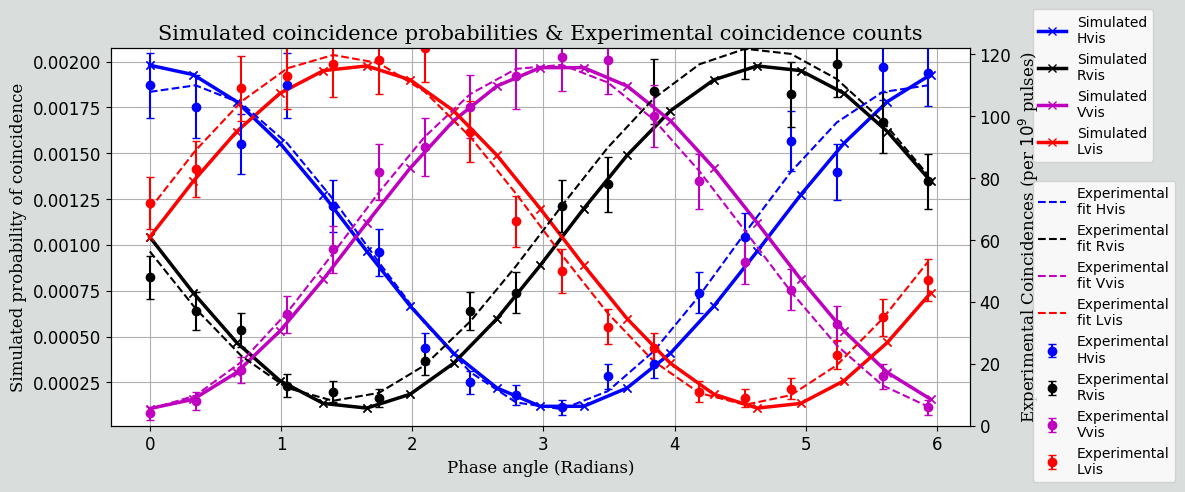

In [39]:
print(coincidences)
json.dump({0:coincidences}, open("distribution_data.json", "w"))

data_file = open("distribution_data.json", 'r')
coincidences = json.load(data_file)['0']

min_diff_index = 0
avg_visibility = 0

for i in range(len(params["idler_angles"])):
    visibility = (max(coincidences[min_diff_index][i]) - min(coincidences[min_diff_index][i]))/(max(coincidences[min_diff_index][i]) + min(coincidences[min_diff_index][i]))
    avg_visibility += visibility/len(params["idler_angles"])
print("Average visibility:", avg_visibility)

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Creating fitting curves
fringe_domain = np.array(params["signal_angles"])
params0, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][3], p0=(80,1,1,1))

exp_params0, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], H_data[:, 5][:-1], p0=(80,1,1,1))
exp_params1, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], L_data[:, 5][:-1], p0=(80,1,1,1))
exp_params2, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], V_data[:, 5][:-1], p0=(80,1,1,1))
exp_params3, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], R_data[:, 5][:-1], p0=(80,1,1,1))

TNRfont = {'fontname':'serif'}

# Now, creating actual plots.

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12,5))
# ax1.add_patch(rounded_rect)
fig.patch.set_facecolor("#d9dddc")
fig.patch.set_capstyle("round")
plt.xticks(fontsize=12)
ax1.set_xlabel('Phase angle (Radians)', **TNRfont, fontsize = 12)
ax1.set_ylabel('Simulated probability of coincidence', **TNRfont, fontsize = 12)

# Plotting Simulation data
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][0][:-1], 'bx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][1][:-1], 'kx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][2][:-1], 'mx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][3][:-1], 'rx')

# Plotting sinusoidal fits
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params0)[:-1], fmt = 'b-x', capsize=3, label = "Simulated\nHvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params1)[:-1], fmt = 'k-x', capsize=3, label = "Simulated\nRvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params2)[:-1], fmt = 'm-x', capsize=3, label = "Simulated\nVvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params3)[:-1], fmt = 'r-x', capsize=3, label = "Simulated\nLvis", linewidth = 2.5)

plt.legend(loc = 'upper left')

# # Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.yticks(fontsize=12)
ax1.legend(loc='center left', bbox_to_anchor=(1.065, 0.9))


# Create second axis
ax2 = ax1.twinx()
ax2.set_ylim([0, max(max(H_data[:, 5][:-1]), max(V_data[:, 5][:-1]), max(L_data[:, 5][:-1]))])
ax2.set_ylabel(r'Experimental Coincidences (per $10^9$ pulses)', **TNRfont, fontsize = 12)

# plotting experimental data
ax2.errorbar(experimental_domain[:-1], H_data[:, 5][:-1], yerr = np.sqrt(H_data[:, 5][:-1]), fmt = 'bo', capsize=3, label = "Experimental\nHvis")
ax2.errorbar(experimental_domain[:-1], R_data[:, 5][:-1], yerr = np.sqrt(R_data[:, 5][:-1]), fmt = 'ko', capsize=3, label = "Experimental\nRvis")
ax2.errorbar(experimental_domain[:-1], V_data[:, 5][:-1], yerr = np.sqrt(V_data[:, 5][:-1]), fmt = 'mo', capsize=3, label = "Experimental\nVvis")
ax2.errorbar(experimental_domain[:-1], L_data[:, 5][:-1], yerr = np.sqrt(L_data[:, 5][:-1]), fmt = 'ro', capsize=3, label = "Experimental\nLvis")

# Plotting experimental sinusoidal fits
ax2.plot(experimental_domain[:-1], sinusoid(experimental_domain[:-1], *exp_params0), 'b',  label = "Experimental\nfit Hvis", linestyle='dashed')
ax2.plot(experimental_domain[:-1], sinusoid(experimental_domain[:-1], *exp_params3), 'k',  label = "Experimental\nfit Rvis", linestyle='dashed')
ax2.plot(experimental_domain[:-1], sinusoid(experimental_domain[:-1], *exp_params2), 'm',  label = "Experimental\nfit Vvis", linestyle='dashed')
ax2.plot(experimental_domain[:-1], sinusoid(experimental_domain[:-1], *exp_params1), 'r',  label = "Experimental\nfit Lvis", linestyle='dashed')



# Put a legend to the right of the current axis
ax2.legend(loc='center left', bbox_to_anchor=(1.065, 0.25))

plt.yticks(fontsize=12)
ax1.set_title("Simulated coincidence probabilities & Experimental coincidence counts", **TNRfont, fontsize = 15)
ax1.grid()
plt.tight_layout()

fig.savefig("/home/asingal/home/SeQUeNCe/sequence_projects/TQE_final_data/distribution_fringes.svg", format = 'svg')

## Estimating system attenuation

We now present a use case of the simulator. We try to estimate the net attenuation in the system (including detector inefficiencies, equipment losses and polarization misalignment). The code sweeps across a few values of possible loss valeus (treated as detector inefficiency to simplify implementation) and calculates the difference between the peak coincidence values from the experiemnt with that produced by simulations. 

In [7]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []

# New parameters for estimating system attenuation
det_effs = np.linspace(-21, -22, 15)
params["signal_angles"] = np.linspace(0, 2*np.pi, 20)
params["idler_angles"] = [0]
params["truncation"] = 4

for eff in det_effs:
    params["SIGNAL_DET_EFFICIENCY"] = 10**(eff/10)
    params["IDLER_DET_EFFICIENCY"] = 10**(eff/10)

    timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = params["truncation"])
    signal_receiver, source_node = setup_network(timeline, params)

    for idler_phase in params["idler_angles"]:    

        print("\nNew Idler phase:", idler_phase)
        signal_receiver.rotateIdler(idler_phase)
        for signal_phase in params["signal_angles"]:
            
            timeline.init()
            print("New Signal phase:", signal_phase)
            signal_receiver.rotateSignal(signal_phase)

            for j in range(params["num_bs_trials_per_phase"]):
                source_node.start()
                timeline.run()

            signal_receiver.collectSignalData()
        signal_receiver.reset()

    new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
    signal_singles.append(new_signal_singles.copy())
    idler_singles.append(new_idler_singles.copy())
    coincidences.append(new_coincidences.copy())
    coincidence_std.append(new_coincidence_std.copy())


New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586

New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New

In [8]:
# This is the average coincidence probability for the 4 measurement basis for 4 seconds of 250MHz pulsed opration
# (10^9 pulses in total) for the C22_C46 operation case in [1]. 
reference_probability = 1.1725e-7

# Using that refernece probability, we find the value of system attenuation that we sweeped over in the last cell 
# that corresponds to the least difference with the reference coincidence probability. 
peak_coincidence_probs = []
min_diff = 1
min_diff_index = -1
for i in range(len(det_effs)):
    # print(len(coincidences[i]))
    probability = max(coincidences[i][0])
    print(probability)
    diff = np.abs(probability - reference_probability)
    peak_coincidence_probs.append(probability - reference_probability)
    if diff < min_diff:
        min_diff_index = i
        min_diff = diff
print(det_effs)
print(f"system attenuation estimate: {det_effs[min_diff_index]} dB")


1.602387576644555e-07
1.5505450848388236e-07
1.5003797214405464e-07
1.4518372390160965e-07
1.4048651462698074e-07
1.3594126448414168e-07
1.3154305775930712e-07
1.27287138094426e-07
1.2316890367805292e-07
1.1918389944797652e-07
1.1532781633521823e-07
1.1159648421977822e-07
1.0798586729287437e-07
1.0449206083763403e-07
1.0111128580039646e-07
[-21.         -21.07142857 -21.14285714 -21.21428571 -21.28571429 -21.35714286 -21.42857143 -21.5        -21.57142857 -21.64285714 -21.71428571 -21.78571429 -21.85714286 -21.92857143 -22.        ]
system attenuation estimate: -21.714285714285715 dB


det eff -21.678679937858224


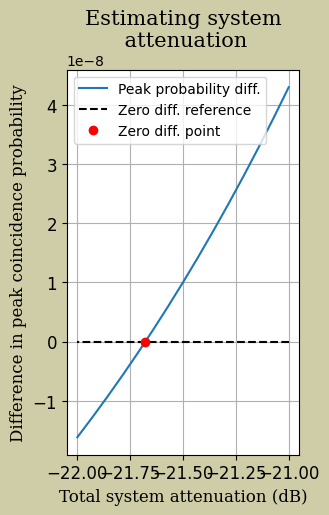

In [40]:
# Data acquisition and plotting
TNRfont = {'fontname':'serif'}

json.dump({"peak_coinc_prob":peak_coincidence_probs}, open("attenuation_data.json", "w"))

data_file = open("attenuation_data.json", 'r')
peak_coincidence_probs = json.load(data_file)['peak_coinc_prob']

fig, ax1 = plt.subplots(figsize=(3,5))
fig.patch.set_facecolor("#cfcda7")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.plot(det_effs, peak_coincidence_probs, label = "Peak probability diff.")
plt.plot(det_effs, [0]*len(det_effs), color = "black", linestyle='dashed', label = "Zero diff. reference")

x = np.array(peak_coincidence_probs)
idx = np.argwhere(np.diff(np.sign(x))).flatten()[0]

# Linearly interpolating correct system attenuation 
interpolated_det_eff = det_effs[idx] - x[idx] * (det_effs[idx]-det_effs[idx+1])/(x[idx]-x[idx+1])
interpolated_diff = (x[idx]-x[idx+1])/(det_effs[idx]-det_effs[idx+1])*(interpolated_det_eff-det_effs[idx])+x[idx]

print("det eff", interpolated_det_eff)
plt.plot(interpolated_det_eff, interpolated_diff, 'ro', label = "Zero diff. point")
plt.title("Estimating system\n attenuation", **TNRfont, fontsize = 15)
plt.xlabel("Total system attenuation (dB)", **TNRfont, fontsize = 12)
ax1.set_ylabel("Difference in peak coincidence probability", **TNRfont, fontsize = 12)
plt.grid()
plt.legend()

This graph shows the variartion of the difference in the peak coincidece probabilities between the simulation and experiment and we simply find the system attenuation corresponding to the minimum difference, which in this case, came out to be 21.67 dB worth of loss. 


## Local Hilbert space study

We analyze the effects of increasing the photon number cut off in the simulations. We lok at the effect of increasing the truncation on two parameters to understand the restriction that such Hilbert space truncation applies. We study two parameters in particular:

<ol>
    <li> Marginal change in entanglement visibility when increasing the truncation value. We expect that as we increase the truncation value, the change in visibilities should reduce rapidly (for low mean photon number simulations)</li>
    <li>Time it takes to perform the simulations versus the truncation value. </li>
</ol>

In [10]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []
times = []

# New parameters for estimating system attenuation
truncations = [1,2,3,4,5,6,7]
params["signal_angles"] = np.linspace(0, 2*np.pi, 20)
params["idler_angles"] = [0]

for trunc in truncations:
    start_time = time()
    timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc)
    signal_receiver, source_node = setup_network(timeline, params)

    for idler_phase in params["idler_angles"]:    

        print("\nNew Idler phase:", idler_phase)
        signal_receiver.rotateIdler(idler_phase)
        for signal_phase in params["signal_angles"]:
            
            timeline.init()
            print("New Signal phase:", signal_phase)
            signal_receiver.rotateSignal(signal_phase)

            for j in range(params["num_bs_trials_per_phase"]):
                source_node.start()
                timeline.run()

            signal_receiver.collectSignalData()
        signal_receiver.reset()
    
    time_taken = time()-start_time
    print("time taken:", time_taken)
    times.append(time_taken)
    new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
    signal_singles.append(new_signal_singles.copy())
    idler_singles.append(new_idler_singles.copy())
    coincidences.append(new_coincidences.copy())
    coincidence_std.append(new_coincidence_std.copy())


New Idler phase: 0
New Signal phase: 0.0


New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586
time taken: 1.6885581016540527

New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal pha

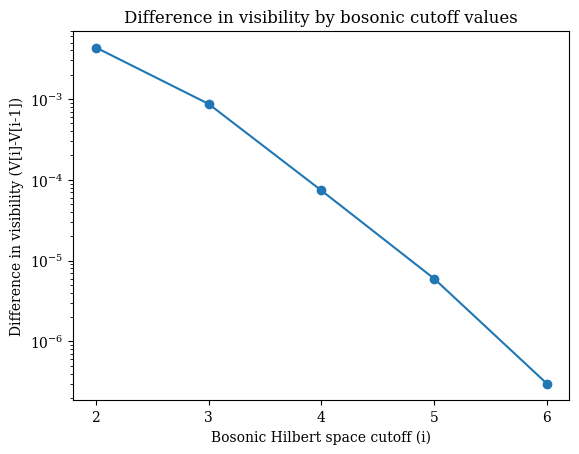

In [11]:
from matplotlib.ticker import MaxNLocator

vis = []
for coincidence in coincidences:
    vis.append((max(coincidence[0]) - min(coincidence[0]))/(max(coincidence[0]) + min(coincidence[0])))
vis_diffs = [np.abs(vis[i-1]-vis[i]) for i in range(1, len(vis)-1)]

fig, ax = plt.subplots()
ax.plot(truncations[1:-1], vis_diffs, '-o')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Difference in visibility by bosonic cutoff values")
plt.xlabel("Bosonic Hilbert space cutoff (i)")
plt.ylabel("Difference in visibility (V[i]-V[i-1])")
plt.yscale("log")

We can see that as the bosonic hiilbert space cutoff is increased, the marginal entanglement distribution decreases rapidly, as expected

Text(0, 0.5, 'Time taken (s)')

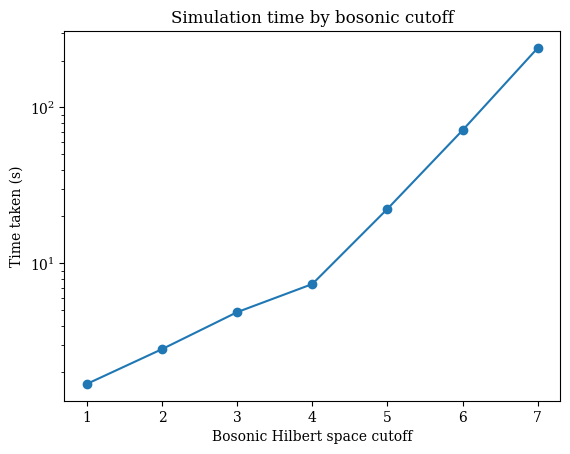

In [12]:
fig, ax = plt.subplots()
ax.plot(truncations, times, '-o')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.yscale("log")
plt.title("Simulation time by bosonic cutoff")
plt.xlabel("Bosonic Hilbert space cutoff")
plt.ylabel("Time taken (s)")

We see that as the bosonic Hilbert space cutoff is increased, the time it takes to perform the simulations grows near exponentially. 